In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import sys
from scipy.stats import poisson
from scipy.integrate import quad,simps, dblquad
from chainconsumer import ChainConsumer
import pyccl as ccl
%load_ext autoreload
import CL_COUNT_MVP_cluster_abundance_prediction as mvp
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count
import DATAOPS_Fisher_matrix as fisher
forecast = fisher.Forecast()

# Define model

In [2]:
#define binning for Binned likelihood
z_corner = np.linspace(0.1, 2, 21)
logm_corner = np.linspace(14, 15, 31)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

In [3]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 1003)
logm_grid = np.linspace(12,16, 1000)

In [4]:
#Define modeling for cluster abundance
CA = cl_count.ClusterAbundance()
CA.f_sky = .25
CA.sky_area = CA.f_sky*4*np.pi
#Omega_c_true = 0.1109/(0.71**2)
#Omega_b_true = 0.02258/(0.71**2)
Omega_c_true = 0.30711 - 0.048254
Omega_b_true = 0.048254
sigma8_true = .8288
Omegam_true = 0.30711
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
cosmo_true = ccl.Cosmology(Omega_c = Omega_c_true, Omega_b = Omega_b_true, h = 0.71, sigma8 = sigma8_true, n_s=0.96)
True_value = [Omega_c_true + Omega_b_true, sigma8_true]
#define mass definition/halo mass function/halo bias
massdef = ccl.halos.massdef.MassDef('vir', 'critical', c_m_relation=None)
hmd = ccl.halos.MassFuncDespali16(cosmo_true, mass_def=massdef)
halobais = ccl.halos.hbias.HaloBiasTinker10(cosmo_true, mass_def=massdef, mass_def_strict=True)
CA.set_cosmology(cosmo = cosmo_true, hmd = hmd, massdef = massdef)
#calculate interpolated multiplicity function
CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
#compute predicted cluster abundance in Z_bin and logMass_bin
N_th_true_cosmo = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')

In [5]:
def model(theta):
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    N_th = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
    return N_th.flatten()

# Binned

## Poissonian

In [6]:
cov_SN_true_cosmo = np.diag(N_th_true_cosmo.flatten())

## Poissonian + SSC covariance matrix

In [7]:
sys.path.append('/pbs/throng/lsst/users/cpayerne/PySSC/')
import PySSC

In [8]:
z_arr = np.linspace(.10,2.3,2000)
nbins_T   = len(z_corner)-1
windows_T = np.zeros((nbins_T,len(z_arr)))
for i, z_bin in enumerate(Z_bin):
    Dz = z_bin[1]-z_bin[0]
    z_arr_cut = z_arr[(z_arr > z_bin[0])*(z_arr < z_bin[1])]
    for k, z in enumerate(z_arr):
        if ((z>z_bin[0]) and (z<=z_bin[1])):
            windows_T[i,k] = 1/Dz

In [9]:
Sij = PySSC.Sij(z_arr,windows_T)

In [10]:
LogM, Z = np.meshgrid(np.mean(logMass_bin, axis = 1), np.mean(Z_bin, axis = 1))
index_LogM, index_Z =  np.meshgrid(np.arange(len(logMass_bin)), np.arange(len(Z_bin)))

In [11]:
def SSC(logMass_bin, Z_bin):
    len_mat = len(Z_bin)*len(logMass_bin)
    cov_SSC = np.zeros([len_mat, len_mat])
    for i, Ni in enumerate(N_th_true_cosmo.flatten()):
        z_mean_i = Z.flatten()[i]
        index_z_i = index_Z.flatten()[i]
        logm_mean_i = LogM.flatten()[i]
        for j, Nj in enumerate(N_th_true_cosmo.flatten()):
            z_mean_j = Z.flatten()[j]
            index_z_j = index_Z.flatten()[j]
            logm_mean_j = LogM.flatten()[j]
            hbi = halobais.get_halo_bias(cosmo_true, 10**logm_mean_i, 1/(1 + z_mean_i), mdef_other = massdef)
            hbj = halobais.get_halo_bias(cosmo_true, 10**logm_mean_j, 1/(1 + z_mean_j), mdef_other = massdef)
            cov_SSC[i,j] = hbi * hbj * Ni * Nj * Sij[index_z_i,index_z_j]
    return cov_SSC/CA.f_sky

In [12]:
cov_SSC = SSC(logMass_bin, Z_bin)

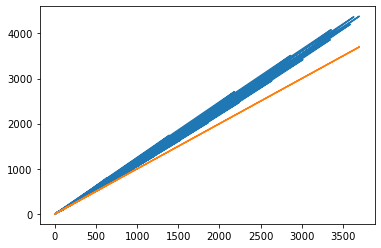

In [13]:
plt.plot(N_th_true_cosmo.flatten(), N_th_true_cosmo.flatten() + cov_SSC.diagonal())
plt.plot(N_th_true_cosmo.flatten(), N_th_true_cosmo.flatten())

In [14]:
cov_SN = np.diag(N_th_true_cosmo.flatten())
cov_SN_SV = np.diag(N_th_true_cosmo.flatten()) + cov_SSC

In [15]:
F_SN = forecast.Fisher_Matrix_Gaussian(True_value, model, cov_SN, delta = 1e-5)
cov_p_SN = np.linalg.inv(F_SN)
F_SN_SV = forecast.Fisher_Matrix_Gaussian(True_value, model, cov_SN_SV, delta = 1e-5)
cov_p_SN_SV = np.linalg.inv(F_SN_SV)

# Unbinned
## Poissonian

In [16]:
N_th_cosmo_true_unbinned = CA.Cluster_Abundance_MZ(Redshift_bin = [[z_corner[0], z_corner[-1]]], 
                                   Proxy_bin = [[logm_corner[0], logm_corner[-1]]], method = 'simps')

In [17]:
def model_Ntot(theta):
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    N_th = CA.Cluster_Abundance_MZ(Redshift_bin = [[z_corner[0], z_corner[-1]]], 
                                   Proxy_bin = [[logm_corner[0], logm_corner[-1]]], method = 'simps')
    return N_th[0][0]

In [18]:
a = model_Ntot(True_value)

In [19]:
Ntot_second_derivative = forecast.second_derivative(True_value, model_Ntot, a.shape)

In [20]:
def model_grid_ln(theta):
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    return np.log(CA.sky_area*CA.dN_dzdlogMdOmega)

In [21]:
def av_ln_multiplicity_n(theta, model, delta = 1e-5):
    model_true = np.exp(model(theta))
    pdf = model_true/N_th_cosmo_true_unbinned
    index_z_grid = np.arange(len(z_grid))
    index_logm_grid = np.arange(len(logm_grid))
    mask_z = (z_grid > z_corner[0])*(z_grid < z_corner[-1])
    mask_logm = (logm_grid > logm_corner[0])*(logm_grid < logm_corner[-1])
    index_z_mask = index_z_grid[mask_z]
    index_logm_mask = index_logm_grid[mask_logm]
    res = np.zeros([len(theta),len(theta)])
    sec_derivative = forecast.second_derivative(True_value, model_grid_ln, model_true.shape)
    for i in range(len(theta)):
        for j in range(len(theta)):
            integrand = sec_derivative[i,j] * pdf
            integrand_cut = np.array([integrand[:,i][mask_logm] for i in index_z_mask])
            res[i,j] = simps(simps(integrand_cut, logm_grid[mask_logm]),z_grid[mask_z])
    return  res 

In [22]:
av_ln_lambda = av_ln_multiplicity_n(True_value, model_grid_ln, delta = 1e-5)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:54: RuntimeWarning: invalid value encountered in subtract
  2*model(theta) + \
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:59: RuntimeWarning: invalid value encountered in subtract
  model(theta-delta_i+delta_j) + \


In [23]:
Fisher_unbinned = Ntot_second_derivative - N_th_cosmo_true_unbinned * av_ln_lambda
cov_p_unbinned_SN = np.linalg.inv(Fisher_unbinned)

# MVP

In [24]:
%load_ext autoreload
%autoreload 2
import CL_COUNT_MVP_cluster_abundance_prediction as mvp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
cov_SSC_diag = cov_SSC.diagonal()

In [26]:
MVP = mvp.MVP(N_th_true_cosmo.flatten(), cov_SSC_diag)
MVP._set_axis(3, N_th_true_cosmo.flatten(), cov_SSC_diag)

In [27]:
def ln_P_mvp_grid(theta):
    P_grid = np.zeros([len(N_th_true_cosmo.flatten()), MVP.n_max])
    Omegab = Omega_b_true
    Omegam, sigma8 = theta
    cosmo_new = ccl.Cosmology(Omega_c = Omegam - Omegab, Omega_b = Omegab, h = 0.71, sigma8 = sigma8, n_s=0.96)
    hmd_new = ccl.halos.MassFuncDespali16(cosmo_new, mass_def=massdef)
    CA.set_cosmology(cosmo = cosmo_new, hmd = hmd_new, massdef = massdef)
    CA.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
    N_th = CA.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps').flatten()
    N, P = MVP.p_mvp(N_th.flatten(), cov_SSC_diag)
    for i, n_th in enumerate(N_th):
        P_grid[i,:][N[i]] = P[i]
    return np.log(P_grid)

In [28]:
ln_P = ln_P_mvp_grid(True_value)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  P_MVP = np.array([P_MVP_table[indexes] for indexes in self.split_indexes])
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [29]:
ln_P.shape

(600, 3898)

In [30]:
from scipy.stats import multivariate_normal

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  del sys.path[0]


(0.0, 0.1)

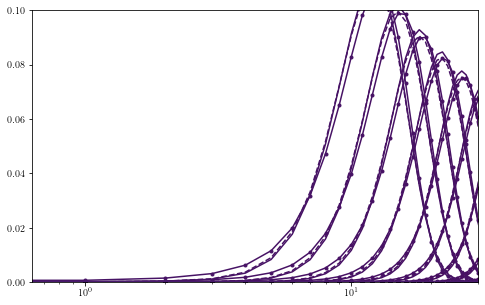

In [42]:
colors = plt.cm.get_cmap('viridis', len(Z_bin)*len(logMass_bin))
plt.figure(figsize = (8,5))
for i in range(len(N_th_true_cosmo.flatten())):
    if i > 40: break
    rv = poisson(N_th_true_cosmo.flatten()[i])
    N_array = np.arange(0,1e4)
    plt.plot(rv.pmf(N_array),c = colors(i))
    pdf = multivariate_normal.pdf(N_array, mean=N_th_true_cosmo.flatten()[i], 
                                  cov=N_th_true_cosmo.flatten()[i] + cov_SSC_diag[i])
    plt.plot(N_array, pdf/np.sum(pdf), '.-', c = colors(i))
    plt.plot(np.exp(ln_P[i]), '--', c = colors(i))
plt.xscale('log')
plt.xlim(0, 30)
plt.ylim(0, 0.1)

In [32]:
forecast = fisher.Forecast()
first_derivative_ln_P = forecast.first_derivative(True_value, ln_P_mvp_grid, ln_P.shape, delta = 1e-5)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_COUNT_MVP_cluster_abundance_prediction.py:129: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  P_MVP = np.array([P_MVP_table[indexes] for indexes in self.split_indexes])
/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/DATAOPS_Fisher_matrix.py:28: RuntimeWarning: invalid value encountered in subtract
  first[i] = (model(theta + delta_i/2) - model(theta - delta_i/2))/delta


In [33]:
Fisher_matrix_MVP = np.zeros([2,2])
for i in range(2):
    for j in range(2):
        res = 0
        for k in range(len(Z_bin)*len(logMass_bin)):
            mask_finite = np.isfinite(first_derivative_ln_P[i][k])*np.isfinite(first_derivative_ln_P[j][k])
            p = np.exp(ln_P[k][mask_finite])/np.sum(np.exp(ln_P[k][mask_finite]))
            if np.sum(p) == 0: 
                print(N_th_true_cosmo.flatten()[k])
                print(cov_SSC_diag[k]**.5)
            res = res + np.sum(p * first_derivative_ln_P[i][k][mask_finite]*first_derivative_ln_P[j][k][mask_finite])
        Fisher_matrix_MVP[i,j] = res

In [34]:
cov_p_MVP = np.linalg.inv(Fisher_matrix_MVP)

In [35]:
cov_p_MVP

array([[ 1.05103079e-06, -5.17882803e-07],
       [-5.17882803e-07,  3.42724310e-07]])

# plot covariance

In [36]:
data_SN = np.random.multivariate_normal(True_value, cov_p_SN, size=10000)
data_SN_SV = np.random.multivariate_normal(True_value, cov_p_SN_SV, size=10000)
data_unbinned_SN = np.random.multivariate_normal(True_value, cov_p_unbinned_SN, size=10000)
data_MVP = np.random.multivariate_normal(True_value, cov_p_MVP, size=10000)

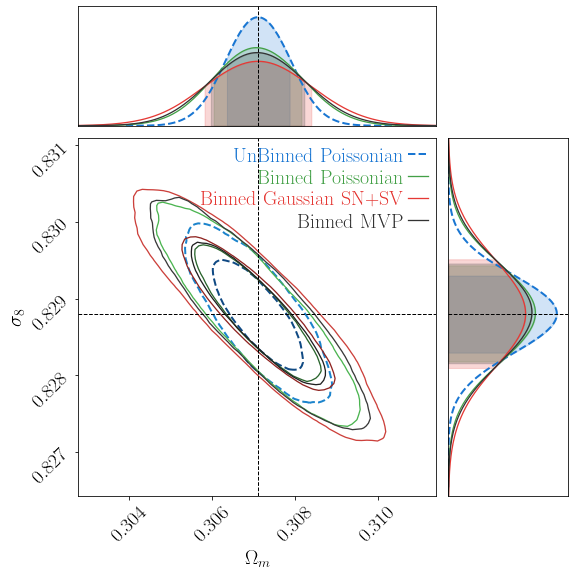

In [37]:
c = ChainConsumer()
c.add_chain(data_unbinned_SN, name="UnBinned Poissonian", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_SN, name="Binned Poissonian", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_SN_SV, name="Binned Gaussian SN+SV", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.add_chain(data_MVP, name="Binned MVP", parameters = [r'$\Omega_m$',r'$\sigma_8$'])
c.configure(kde = [1.5,1.5,1.5,1.5], smooth=[1,1,1,1],linestyles=["--", "-", "-","-"],
            linewidths=[2, 1.3, 1.3, 1.3],
             colors=['b','g','r','k'], shade=[False, False, False,False], 
            shade_alpha = [0.3,.3, .1,1],
            bar_shade=True,
            flip=True,label_font_size=20, 
            tick_font_size=20)
fig = c.plotter.plot(truth = True_value)
fig.set_size_inches(5 + fig.get_size_inches()) 
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/forecast.png', bbox_inches='tight', dpi=300)